# Testing the number of bumps that best explains the data

We usually do not have precise enough information to decide a priori on a number of bumps that an HsM model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper that we already prepared in section 1 of tutorial 1 and saved in ```sample_data/```. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data)


In [2]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hsmm

eeg_data = xr.load_dataset('sample_data/sample_data.nc')

#We create also the position array for the electrodes as we are going to need them to plot the bump topologies
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])#Extract x and y positions of each electrode

## Data preparation

First let's transform the data in principal component (PC) space

In [3]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, samples: 210, participant: 4, electrodes: 30)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
    event        (participant, epochs) object 'SP/stim_right/resp_left' ... '...
Attributes:
    sfreq:    100

When transforming the data, a prompt request us how many PC we want to keep. The best is to maximise the number of component kept so that we don't loose PC with useful information, but the more PC we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PC that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method)

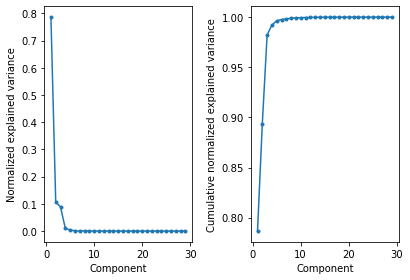

How many PCs (90 and 99% explained variance at component n3 and n4)? 4


In [4]:
unstacked_data = hsmm.utils.transform_data(eeg_data)

hsmm_data = hsmm.utils.stack_data(unstacked_data)

In this case we see that 99% is achieved with 4 PCs and this is globally coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with a lot more PC but the elbow might occur before that)

In [5]:
hsmm_data

<xarray.Dataset>
Dimensions:              (component: 4, all_samples: 52203,
                          trial_x_participant: 722)
Coordinates:
  * component            (component) int64 0 1 2 3
  * all_samples          (all_samples) MultiIndex
  - participant          (all_samples) object '0022' '0022' ... '0025' '0025'
  - epochs               (all_samples) int64 0 0 0 0 0 0 ... 199 199 199 199 199
  - samples              (all_samples) int64 0 1 2 3 4 5 ... 96 97 98 99 100 101
  * trial_x_participant  (trial_x_participant) MultiIndex
  - subjects             (trial_x_participant) object '0022' '0022' ... '0025'
  - trials               (trial_x_participant) int64 0 1 2 3 ... 193 196 197 199
Data variables:
    data                 (component, all_samples) float64 -0.2047 ... -0.07047
    durations            (trial_x_participant) int64 157 238 335 ... 52101 52203

## Fitting from the maximum number of bump to a 1 bump model

One way to decide on a given number is to look at what number of bumps best fits the data (hence the number of bumps with the highest likelihood) by fitting all possible number of bumps from 1 bump to *n* bumps where *n* is given by how many *x* milliseconds bumps fit into a mean reaction time of *y* milliseconds (e.g. a minimum reaction time of 400 ms with 50ms bumps allow for the estimation of up to 8 bumps). The function ```backward_estimation``` allows to do this automatically by first estimating *n* bump model up to 1 bump model (by iteratively removing the weakest bump at each new n_bump, see tutorial 2)

In [6]:
import hsmm_mvpy as hsmm

init = hsmm.models.hsmm(hsmm_data, sf=100, bump_width=50, cpus=5)
bests = init.backward_estimation()
bests

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model with 0 random starting points
Likelihood of uninitialized parameters has been preferred over initialized model. Consider adding starting points?
Parameters estimated for 6 bumps model
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


<xarray.Dataset>
Dimensions:              (n_bumps: 6, stage: 7, params: 2, bump: 6,
                          component: 4, trial_x_participant: 722, samples: 210)
Coordinates:
  * bump                 (bump) int64 0 1 2 3 4 5
  * samples              (samples) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) MultiIndex
  - participant          (trial_x_participant) object '0022' '0022' ... '0025'
  - trials               (trial_x_participant) int64 0 1 2 3 ... 193 196 197 199
  * n_bumps              (n_bumps) int64 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component
Data variables:
    likelihoods          (n_bumps) float64 -2.302e+03 -1.688e+03 ... -3.007e+03
    parameters           (n_bumps, stage, params) float64 2.0 1.453 ... nan nan
    magnitudes           (n_bumps, component, bump) float64 -1.111 -1.2 ... nan
    eventprobs           (n_bumps, trial_x_participant, samples, bump) float64 ...

This leaves us with the following topologies

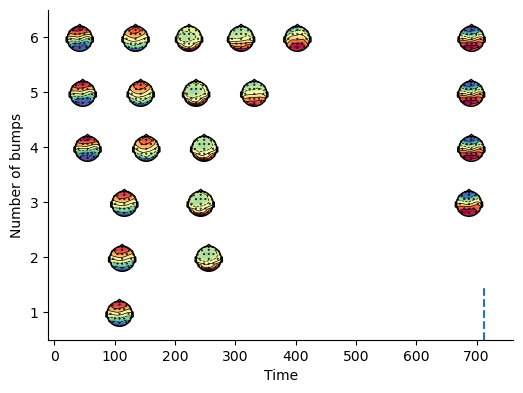

In [7]:
topo_bests = init.multiple_topologies(eeg_data, bests.eventprobs)#Compute electrode activity at the likeliest time of the bumps

hsmm.visu.plot_topo_timecourse(topo_bests, [init.bump_times(x) for x in bests.eventprobs[::-1]],
                          positions, bump_size=init.bump_width_samples, time_step = 1000/eeg_data.sfreq, magnify=2, 
                          times_to_display = np.mean(init.ends - init.starts), ylabels={'Number of bumps':np.arange(init.max_bumps)+1})

But adding more and more parameters will almost always improve the fit (except when bumps start pushing each other) and we might end up adding bumps either to noise or to idiosyncratic data that will not generalize. To illustrate this we can plot the raw likelihood

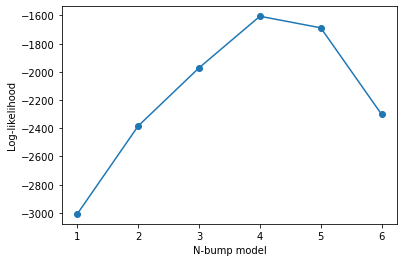

In [8]:
import matplotlib.pyplot as plt 

plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

Hence we need a way to penalize the likelihood if the bumps location do not generalize to all participants. One way to do this is to perform a leave-one out cross-validation. This approach consists in fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters without the participant. The function ```hsmm.utils.LOOCV``` does this and we can apply it to all participants and all *n* bump model.

Note that the LOOCV can be very slow when there are a lot of participants, in this case it might be worth it to add multiprocessing through the cpus parameter

In [9]:
%%time
loocv = hsmm.utils.loocv_mp(init, unstacked_data, bests, cpus=4)#We set the cpus to 4 as their is 4 participants in the dataset


LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)
CPU times: user 312 ms, sys: 507 ms, total: 818 ms
Wall time: 32.7 s


We can then plot the result from the LOOCV procedure

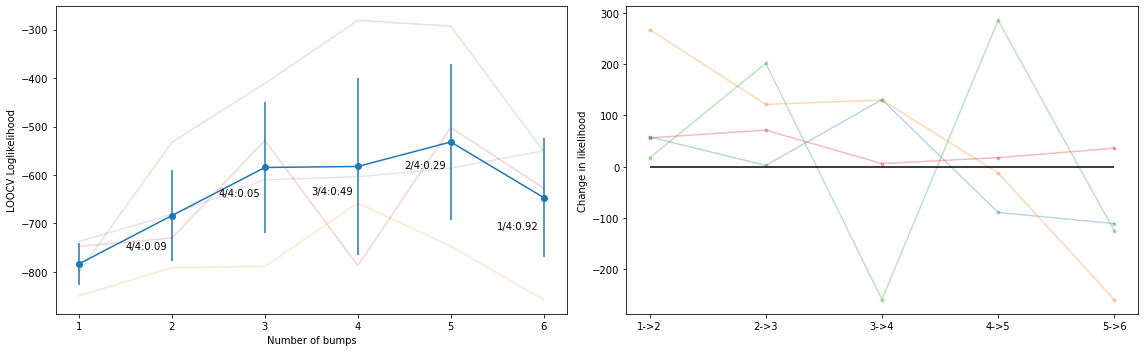

In [10]:
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

Based on the numer of participant that improved (4/4) and the p-value from a one-sided one-sample t-test (<.05), the model with 3 bumps appears to be the prefered model after the LOOCV procedure 

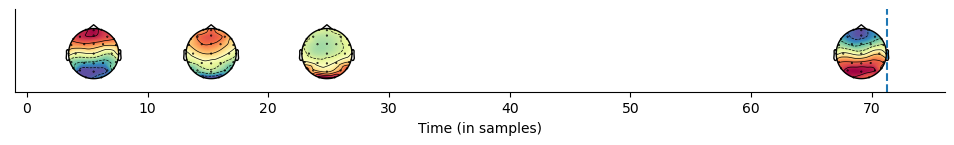

In [11]:
selected = bests.sel(n_bumps=4)
bump_times_selected = init.bump_times(selected.eventprobs)
electrodes_selected = init.compute_topo(eeg_data, selected.eventprobs)

hsmm.visu.plot_topo_timecourse(electrodes_selected, bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=2, figsize=(12,1),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

And we can now inspect specific aspects of that fit, see the next tutorial